In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import torch
import torchvision
import sys
sys.path.append('/user_data/mmhender/imStat/code/')
from utils import nsd_utils

In [3]:
# Loading some images - can use any images at all here for testing.
subject=1; 
images = nsd_utils.get_image_data(subject)
images = nsd_utils.image_uncolorize_fn(images)
images.shape


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


(10000, 1, 240, 240)

In [4]:
def pix_to_deg(number_in_pixels, image_size_pix=227, degrees_per_image=10):
    """
    Convert from pixels to degrees visual angle. 
    Based on specifying size of your image in pixels, and assumed degrees per image.
    """
    degrees_per_pixel = degrees_per_image / image_size_pix    
    number_in_deg = number_in_pixels * degrees_per_pixel
    return number_in_deg

def deg_to_pix(number_in_deg, image_size_pix=227, degrees_per_image=10):
    """
    Convert from degrees visual angle to pixels.
    Based on specifying size of your image in pixels, and assumed degrees per image.
    """
    degrees_per_pixel = degrees_per_image / image_size_pix    
    number_in_pixels = number_in_deg / degrees_per_pixel
    return number_in_pixels


In [5]:
# Some resources on how this works - subtracting one gaussian filtered image from another
# https://scikit-image.org/docs/dev/auto_examples/filters/plot_dog.html
# https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.difference_of_gaussians
# https://pytorch.org/vision/stable/_modules/torchvision/transforms/transforms.html#GaussianBlur

class bandpass_filter:
    """
    Bandpass filter implemented using a difference of two gaussian filters.
    Specify the kernel size (in pixels) and sigma for each of two filters. 
    Builds off of Torchvision transforms that implement Gaussian blur.
    """
    def __init__(self, kernel_size_hf, kernel_size_lf, sigma_hf, sigma_lf):
        
        self.blur_trf_hf = torchvision.transforms.GaussianBlur(kernel_size=kernel_size_hf, sigma = sigma_hf)
        self.blur_trf_lf = torchvision.transforms.GaussianBlur(kernel_size=kernel_size_lf, sigma = sigma_lf)
        
        self.get_lf_kernel()
        self.get_hf_kernel()
        
    def __call__(self, img: torch.Tensor):
        
        # filter the image with two separate low-pass filters. the cutoff of the two filters is different,
        # creating different amounts of blur. HF is less blurred, LF is more blurred. 
        hf_rep = self.blur_trf_hf(img)
        lf_rep = self.blur_trf_lf(img)

        # create the band-pass filtered image by subtracting more-blurred from less-blurred.
        bp_rep = hf_rep - lf_rep

        return bp_rep
    
    def get_lf_kernel(self):
    
        kernel_size = self.blur_trf_lf.kernel_size
        center = np.ceil(np.array(kernel_size)/2).astype('int')
        mask = np.zeros((1,1,kernel_size[0]+2, kernel_size[1]+2))
        mask[0,0,center, center] = 1

        mask_tensor = torch.tensor(mask)
        kernel_tensor = self.blur_trf_lf(mask_tensor)
        kernel = kernel_tensor.detach().cpu().numpy()[0,0,:,:]
        krange = [np.where(kernel[center[0],:]!=0)[0][0], np.where(kernel[center[0],:]!=0)[0][-1]]

        kernel_cropped = kernel[krange[0]:krange[1]+1, krange[0]:krange[1]+1]

        self.lf_kernel = kernel_cropped

    def get_hf_kernel(self):
    
        kernel_size = self.blur_trf_hf.kernel_size
        center = np.ceil(np.array(kernel_size)/2).astype('int')
        mask = np.zeros((1,1,kernel_size[0]+2, kernel_size[1]+2))
        mask[0,0,center, center] = 1

        mask_tensor = torch.tensor(mask)
        kernel_tensor = self.blur_trf_hf(mask_tensor)
        kernel = kernel_tensor.detach().cpu().numpy()[0,0,:,:]
        krange = [np.where(kernel[center[0],:]!=0)[0][0], np.where(kernel[center[0],:]!=0)[0][-1]]

        kernel_cropped = kernel[krange[0]:krange[1]+1, krange[0]:krange[1]+1]

        self.hf_kernel = kernel_cropped
        

In [8]:
# Specify the frequency to filter. This is in cycles/degree.
range_cyc_per_deg = np.array([1, 4]) 

# now convert from frequency to bandwidth of the gaussian. 
range_deg_per_cyc = 1/range_cyc_per_deg

# sigma has to be specified in pixels, so convert to pixels here.
sigma_lf = deg_to_pix(range_deg_per_cyc[0]).astype('int')
sigma_hf = deg_to_pix(range_deg_per_cyc[1]).astype('int')

# to make the falloff of the filter smooth, we need to make the filter bigger than the standard deviation 
# of the gaussian. Starting with 4x because this makes it go out 2 SD in each direction. 
# Could adjust this as needed.
kernel_size_hf=sigma_hf*1+2
kernel_size_lf=sigma_lf*1+1

# Creating the bandpass filter here. 
tf = bandpass_filter(kernel_size_hf, kernel_size_lf, sigma_hf, sigma_lf)

# due to rounding etc, the effective frequency may not be identical to what was entered. 
actual_freq_hf = 1/pix_to_deg(sigma_hf)
actual_freq_lf = 1/pix_to_deg(sigma_lf)
print([actual_freq_lf, actual_freq_hf])

[1.0318181818181817, 4.54]


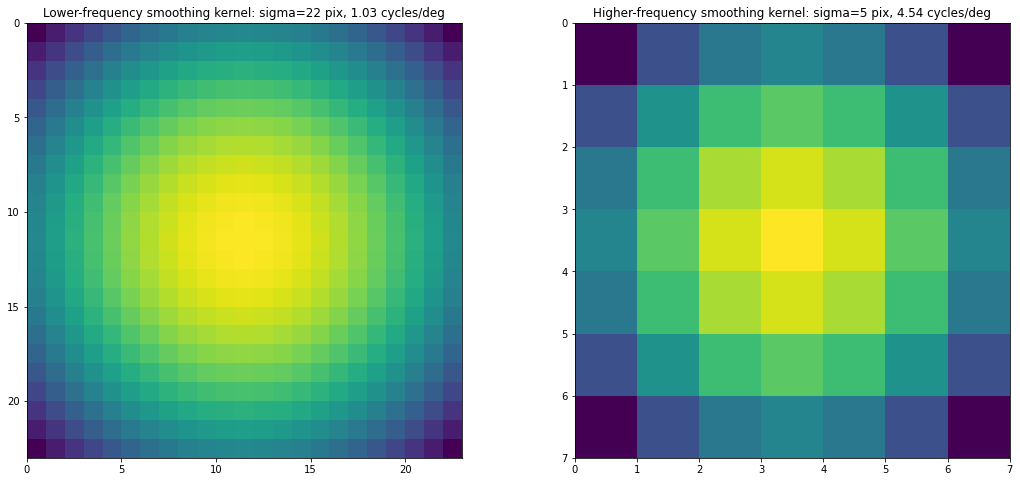

In [112]:
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.pcolormesh(tf.lf_kernel)
plt.axis('square')
plt.gca().invert_yaxis()
plt.title('Lower-frequency smoothing kernel: sigma=%d pix, %.2f cycles/deg'%(sigma_lf, actual_freq_lf));

plt.subplot(1,2,2)
plt.pcolormesh(tf.hf_kernel)
plt.axis('square')
plt.gca().invert_yaxis()
plt.title('Higher-frequency smoothing kernel: sigma=%d pix, %.2f cycles/deg'%(sigma_hf, actual_freq_hf));


In [163]:
# Now apply the filter to some images. 

image_inds = np.arange(0,2,1)

image = images[image_inds,:,:,:]
image_tensor = torch.tensor(image)
bp_tensor = tf(image_tensor)
bp = bp_tensor.detach().cpu().numpy()


In [162]:
lf_weight_tensor = torch.tensor(tf.lf_kernel).view([1,1,tf.lf_kernel.shape[0],-1]).float()
pad_by = (int(np.floor(lf_weight_tensor.shape[2]/2)), int(np.floor(lf_weight_tensor.shape[3]/2)))
lf_filt_tensor = torch.nn.functional.conv2d(image_tensor, lf_weight_tensor, padding=pad_by)

In [149]:
hf_weight_tensor = torch.tensor(tf.hf_kernel).view([1,1,tf.hf_kernel.shape[0],-1]).float()
pad_by = (int(np.floor(hf_weight_tensor.shape[2]/2)), int(np.floor(hf_weight_tensor.shape[3]/2)))
hf_filt_tensor = torch.nn.functional.conv2d(image_tensor, hf_weight_tensor, padding=pad_by)

In [158]:
# bp = hf_filt_tensor - lf_filt_tensor

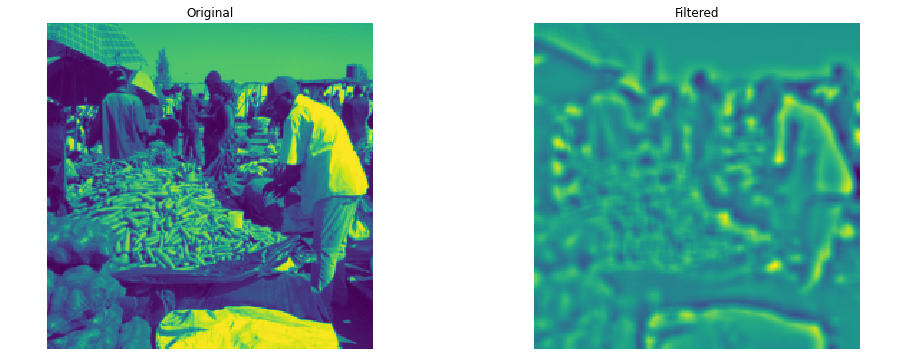

In [164]:
# Plot the result

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pcolormesh(image[0,0,:,:])
plt.axis('equal')
plt.axis('off')
plt.gca().invert_yaxis()
plt.title('Original');

plt.subplot(1,2,2)
plt.pcolormesh(bp[0,0,:,:])
plt.axis('equal')
plt.axis('off')
plt.gca().invert_yaxis()
plt.title('Filtered');

# plt.subplot(1,3,3)
# plt.pcolormesh()
# plt.axis('equal')
# plt.axis('off')
# plt.gca().invert_yaxis()
# plt.title('Filtered');


In [165]:
# Computing some basic parameters of screen/conversion factors
deg_per_image = 10 # this is an assumption
pix_per_image = images.shape[2] 
pix_per_deg = pix_per_image / deg_per_image
sampling_rate = 1/pix_per_image # 1 sample per pixel
# when we do a fourier transform, what are the x and y axes?
freq_space_cycles_per_pixel = np.arange(-0.5, 0.5, sampling_rate) 
freq_space_cycles_per_deg = freq_space_cycles_per_pixel  * pix_per_deg

# computing the maximum possible frequency that we can detect in the image
# Nyquist limit, 1/2 the sampling rate
nyq_cyc_per_pixel = 1/2
degrees_per_pixel = deg_per_image / pix_per_image
nyq_cyc_per_deg = nyq_cyc_per_pixel / degrees_per_pixel
print(nyq_cyc_per_deg)

11.35


Text(0.5, 1.0, 'Filtered, fft')

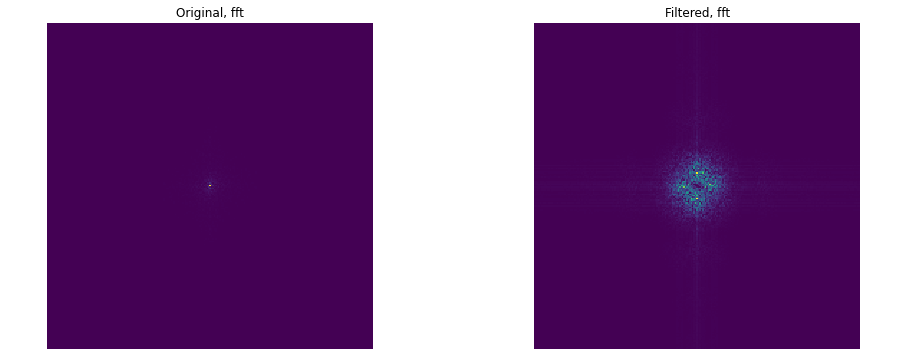

In [166]:
# Plot the frequency-domain representation of the image, before and after filtering. 

im_fft = np.fft.fftshift(np.fft.fftn(image, axes=[2,3]))
im_tf_fft = np.fft.fftshift(np.fft.fftn(bp, axes=[2,3]))

mean_fft = np.abs(np.mean(im_fft[:,0,:,:], axis=0))
mean_tf_fft = np.abs(np.mean(im_tf_fft[:,0,:,:], axis=0))

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pcolormesh(mean_fft)
plt.axis('equal')
plt.axis('off')
plt.gca().invert_yaxis()
plt.title('Original, fft')

plt.subplot(1,2,2)
plt.pcolormesh(mean_tf_fft)
plt.axis('equal')
plt.axis('off')
plt.gca().invert_yaxis()
plt.title('Filtered, fft')

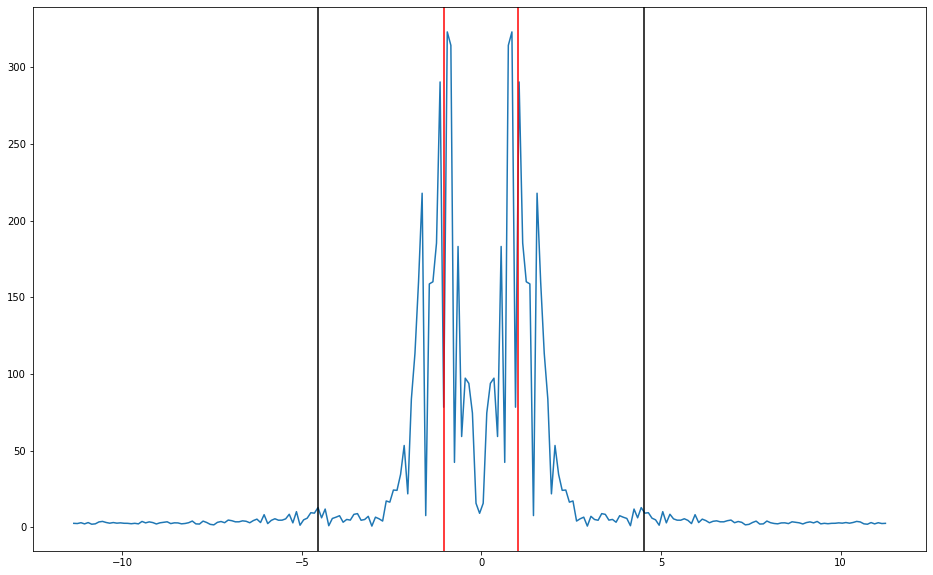

In [167]:

plt.figure(figsize=(16,10))
# plt.plot(freq_space_cycles_per_deg, mean_tf_fft[113,:])
plt.plot(freq_space_cycles_per_deg, np.abs(im_tf_fft[0,0,113,:]))


plt.axvline(actual_freq_hf,color='k')
plt.axvline(-actual_freq_hf,color='k')
plt.axvline(actual_freq_lf,color='r')
plt.axvline(-actual_freq_lf,color='r')

# plt.axvline(sig_lf,color='b')
# plt.axvline(-sig_lf,color='b')
# plt.axvline(sig_hf,color='g')
# plt.axvline(-sig_hf,color='g')

In [ ]:
import
vals = np.arange(255)
c = (np.max(vals) - np.min(vals))/(np.max(vals)+np.max_vals)
c